# Capstone: Leveraging NLP for Improved Movie Rating Predictions

Part 2

Author: Michael Rong

Date: April 3rd, 2023


1. [Introduction to the Notebook](#introduction-to-the-notebook)   
   
2. [Review Dataset](#initial-exploration-of-the-data)

3. [Sentiment Analysis](#Sentiment-Analysis)

5. [Notebook Conclusion](#notebook-conclusion)

# Introduction to the Notebook


This notebook will be focused primarily on the second dataset which contains movie review texts. Sentiment analysis will be done using 'Term Frequency Inverse Document Frequency' (TFIDF) to vectorize words indicating positive and negative sentiment. After that is done, the vectorized words will be joined back into our working dataset.

By the end of the notebook, we will have a Train, Validation, and Test set ready to used for our machine learning models.

# Review Dataset

The review dataset from Movielens contains roughly 2.5 million individual reviews obtained from IMDB. We will be taking a portion of this data that corresponds to the movies found in our Movie ratings dataset and compiling them together. 

First let's take a look at the data itself.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',100000000)

In [80]:
# loading the data from the json file

reviews_raw = pd.read_json(r"C:\Users\micha\OneDrive\Desktop\Capstone\movie_dataset_public_final\raw\reviews.json", lines=True)

In [81]:
# Looking at the dataset

reviews_raw.head()

,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita Dancing,"" one of a series of Edison short films featuring \r circus and vaudeville acts, displayed the... um... ""talents"" of a zaftig belly-dancer who agreed to undulate before the camera of the famous ""Black \r Maria"" studio. \r \r The dance was originally intended to be played in a Kinetoscope, a single -person arcade viewer connected to Edison's more famous invention, the phonograph. Through a pair of crude headphones, the latter device supplied an asynchronous soundtrack of ""hootchie-cootchie"" music. \r \r The Kinetograph camera here employed is so new -- even to its inventors \r -- that director Dickson has drastically ""overcranked"" the film, unintentionally producing one of the first examples of slow-motion.\r \r Carmencita's titillating movements were considered by many to be \r scandalous. Thus, the film prompted some of the earliest discussions of film censorship."
1,95541,"Banging Away..; Thomas Edison and William K.L. Dickson's ""Blacksmith Scene,"" was the first film shown publicly in 1893. This short is a brief look at 3 workers as they go about their daily ritual. Great piece of work for its time. In the early days of cinema, directors typically recorded everyday events such as the arrival of ships or workers leaving a factory. These short films were called ""actualities."" Later, with the advent of better equipment (which could record for longer), directors began to introduce more complicated narratives into film. 10* (10* Rating System)"
2,7065,unbelievable; I cannot understand how anyone can call this one of the greatest movies ever made. It is disgraceful and appalling. I guess it is still high entertainment to see white actors in black face and watch a film loaded with stereotype.
3,3739,"I'm still starry-eyed from it; I saw this last night on the Turner Classic Movies station. Wow. This is a perfect, shining, ebullient example of what was possible before The Code. The clever, witty, salacious dialogue! The compromising situations! The sheer sexuality permeating every scene, including the ones where the camera is on this side of a closed door! I am so glad that I finally saw this film, and would own a copy immediately were it available in any format. There's a lesson here. All together now: NEVER AGAIN with the censorship!!!"
4,1562,"Failed on every Front; Joel Schumacher who did an OK job on the third Batman Movie, has simply lost the plot on this one. Poorly cast with the exception of Robin and Ivy, this is far more like the 60's TV series than the comic books, and it just does not work. The Baddies are not menacing, Schwarzenegger rarely performs this badly and Uma Thurman, although she did an OK job was just a poor character. As for Batgirl, this is just too much. Bring back Keaton and Tim Burton and take Batman back to his dark roots. There is no future for Batman if it continues like this. 3/10"


In [82]:
# Shape of data

reviews_raw.shape

(2624608, 2)

From looking at the dataset, there are only 2 columns, the review text, as well as the item_id, we will be using the item_id to join with the corresponding column from our movie ratings dataset.

In [83]:
reviews_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624608 entries, 0 to 2624607
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   item_id  int64 
 1   txt      object
dtypes: int64(1), object(1)
memory usage: 40.0+ MB


In [84]:
# looking for any null values

reviews_raw.isna().sum(axis=0) / reviews_raw.shape[0]*100

item_id    0.0
txt        0.0
dtype: float64

The data seems to be relatively clean, however the size of dataset itself is quite large, for the sake of computational power and time, we will be reducing number of reviews, by only taking up to 75 reviews per item_id. This does not ensure that there are 75 reviews per movie, however we find this to be a good balance between having enough data and run-time efficiency.

In [85]:
# takes up to 75 entries randomly, grouped by item id.

reviews_grouped = reviews_raw.groupby('item_id').apply(lambda x: x.sample(n=min(len(x), 75)))

In [86]:
# resets index

reviews_grouped = reviews_grouped.reset_index(drop = True)

In [87]:
# getting the info,
reviews_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266871 entries, 0 to 1266870
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   item_id  1266871 non-null  int64 
 1   txt      1266871 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.3+ MB


After sampling, the number of entries goes from 2.5 million to 1.26 million entries

The next step, is to group up the review text for each item ID, this is done to avoid having duplicates later when we are joining the dataset. If we were to join the two datasets as is, the movie ratings dataset would have 75 duplicate entries to go with each review text.

We will be creating a new column labeled 'review_texts' and the grouped reviews will be in that column

In [88]:
# groups all the reviews, corresponding to item_id.

groupedtext = reviews_grouped.groupby('item_id')['txt'].apply(list)
review_text_df = pd.DataFrame(groupedtext).reset_index()
review_text_df = review_text_df.rename(columns={'txt': 'review_texts'})

In [89]:
# joins all the reviews together that have the same item_id

review_text_df['review_texts'] = review_text_df['review_texts'].apply(lambda x: ' '.join(x))

In [90]:
review_text_df.head()

item_id  \
0        1   
1        2   
2        3   
3        4   
4        5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [91]:
# fill null values, in case
review_text_df = review_text_df.fillna('')

After organizing the review text data, we will join the movie review data with the review text dataset, we will have to first load in the data from the CSV.

In [ ]:
# Loading previous dataset

linreg_movies_df = pd.read(r'C:\Users\micha\OneDrive\Desktop\Capstone\lin_reg_movies.csv')

In [92]:
# merging datasets on 'item_id' column

movieratings_review_df = linreg_movies_df.merge(review_text_df, on='item_id', how='left')

In [93]:
# Looking at the merged dataset
movieratings_review_df.head(5)

avgRating  item_id  Year  Sentiment  #Movies_directed  actor_count  \
0       7.78        1  1995          1                 6            5   
1       6.53        2  1995          0                 9            4   
2       6.34        3  1995          0                11            4   
3       5.74        4  1995          0                 4            4   
4       6.15        5  1995          0                 7            5   

   Celeb_score  \
0        13.20   
1        13.00   
2        20.00   
3         8.25   
4        15.00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

We can see that the movies are now properly joined, to verify, the first entry in the Movie ratings dataset was 'Toy Story', and in the review text there is mentions of Buzz, Woody, and various other characters from that movie within it.

In [94]:
movieratings_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63769 entries, 0 to 63768
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         63769 non-null  float64
 1   item_id           63769 non-null  int64  
 2   Year              63769 non-null  Int64  
 3   Sentiment         63769 non-null  int32  
 4   #Movies_directed  63769 non-null  int64  
 5   actor_count       63769 non-null  int64  
 6   Celeb_score       63769 non-null  float64
 7   review_texts      44620 non-null  object 
dtypes: Int64(1), float64(2), int32(1), int64(3), object(1)
memory usage: 4.2+ MB


In [95]:
movieratings_review_df.isna().sum(axis=0) / movieratings_review_df.shape[0]*100

avgRating            0.000000
item_id              0.000000
Year                 0.000000
Sentiment            0.000000
#Movies_directed     0.000000
actor_count          0.000000
Celeb_score          0.000000
review_texts        30.028697
dtype: float64

It seems 30% of the data from the review texts is missing. This is from the join of the two datasets, as it is possible not all of the reviews had corresponding item_ids to match them. Dropping the data seems to be the most advisable solution.

In [96]:
# Drop entries where there is null values
movieratings_review_df = movieratings_review_df.dropna()

In [97]:
# gets info
movieratings_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44620 entries, 0 to 47049
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgRating         44620 non-null  float64
 1   item_id           44620 non-null  int64  
 2   Year              44620 non-null  Int64  
 3   Sentiment         44620 non-null  int32  
 4   #Movies_directed  44620 non-null  int64  
 5   actor_count       44620 non-null  int64  
 6   Celeb_score       44620 non-null  float64
 7   review_texts      44620 non-null  object 
dtypes: Int64(1), float64(2), int32(1), int64(3), object(1)
memory usage: 2.9+ MB


After dropping, the dataset is now close to 45 thousand entries, this will be the amount of entries we will be working with for the remainder of the project.

Moving forward, item_id will be dropped as it was only necessary for the join.

In [83]:
# Dropping the item_id column
movieratings_review_df.drop(columns=['item_id'], inplace=True) 

# Sentiment Analysis

Before we start processing the review text, we will split our data into a Train, Validation, and Test set, this is so that we train our model on only certain parts of the data. This will prevent data leakage, ensuring that when we actually 'test' our models, data overlap will not happen where the training data was not actually supposed to 'see' a feature or word it was not supposed to.

In [88]:
# creating rem/test split

# instantiating our independent and dependent variables 
X = movieratings_review_df.drop(columns='avgRating')
y = movieratings_review_df['avgRating']

print(X.shape, y.shape)

(44620, 6) (44620,)


In [89]:
# performing a remainder_test_split to better evaluate our model

# error showing up, ask about this
X_rem, X_test, y_rem, y_test = train_test_split(X,
                                                y,
                                                test_size=0.3,
                                                random_state= 66)

# Checking the shape of the X compared to y
print(X_rem.shape, X_test.shape, y_rem.shape, y_test.shape)

(31234, 6) (13386, 6) (31234,) (13386,)


In [90]:
# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem,
                                                  y_rem,
                                                  test_size=0.2, 
                                                  random_state= 66)

# Checking the shape of the X compared to y
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24987, 6) (6247, 6) (24987,) (6247,)


Creating our custom tokenizer, we are using several components that make up how it works. First we are importing stopwords which are commonly occuring words in the english language that will be filtered. The tokenizer also incorporates stemming, a way of cutting up words allowing for the root word to show, this allows for less variability or confusion when words can very much mean similar in context of a good or bad review (for example, mess, messy, and messiness). The tokenizer also filters out punctuation to avoid having random punctuation that does not convey any meaning in our word analysis.

In [92]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

# allows for stemming words
stemmer = nltk.stem.PorterStemmer()

# Selects english stopwords as a variable
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    """
    Custome tokenizer for preprocessing.
    
    Input: string, raw document.
    Output: list of strings, cleaned & stemmed tokens
    """
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initializing our tokenizer, we will be using a TFIDF vectorizer, which gives a weighting to words based on how frequently they show up in the dataset,this differs from count vectorizers which only shows up term frequency. We will also be including bigrams, which are two words which commonly show up together, the objective is to also see if word combinations such as 'not good' or 'not great' show up, which convey a meaning opposite to their describing component.

In [94]:
import string

# Initialize tokenizer
# include Bigrams
vectorizer = TfidfVectorizer(min_df = 2000, 
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 2))
# fit onto train and test data
vectorizer.fit(X_train['review_texts'])

X_train_transformed = vectorizer.transform(X_train['review_texts'])

X_val_transformed = vectorizer.transform(X_val['review_texts'])

X_test_transformed = vectorizer.transform(X_test['review_texts'])

X_train_transformed.shape

(24987, 4301)

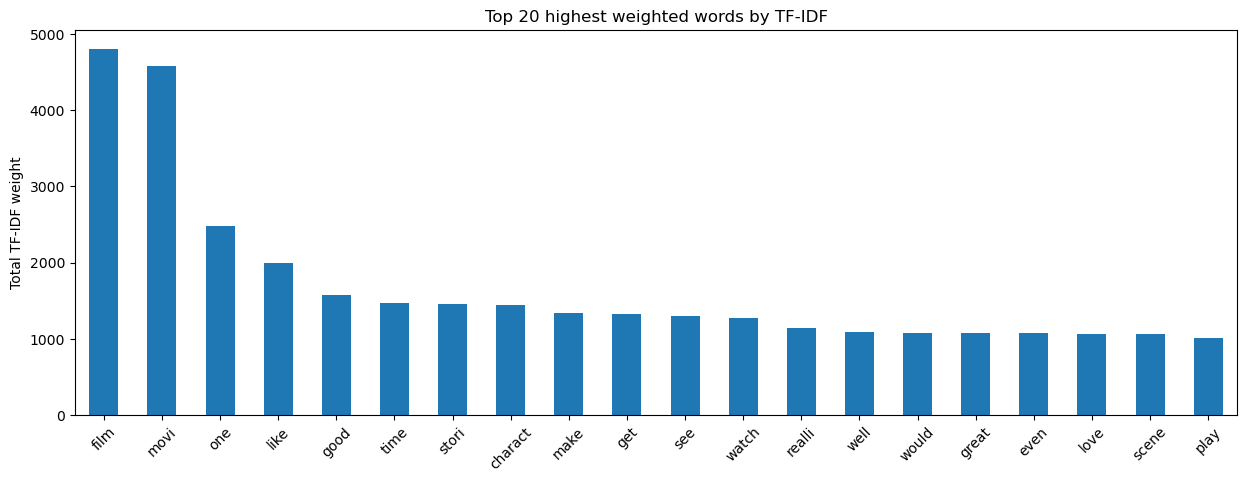

In [95]:
# Using to see what the top words order.
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

From our initial search, we see that the top words are very generic such as film, movie, one, like. which conveys nothing about whether it's a positive or negative review, to filter out these words, we will use a max_df of 0.95 of all documents and see if the words will filter out better

In [98]:
import string

# Initialize tokenizer
vectorizer = TfidfVectorizer(max_df = 0.95,
                             min_df = 2000, 
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 2))
# fit onto train and test data
vectorizer.fit(X_train['review_texts'])

X_train_transformed = vectorizer.transform(X_train['review_texts'])

X_val_transformed = vectorizer.transform(X_val['review_texts'])

X_test_transformed = vectorizer.transform(X_test['review_texts'])

X_train_transformed.shape

(24987, 4298)

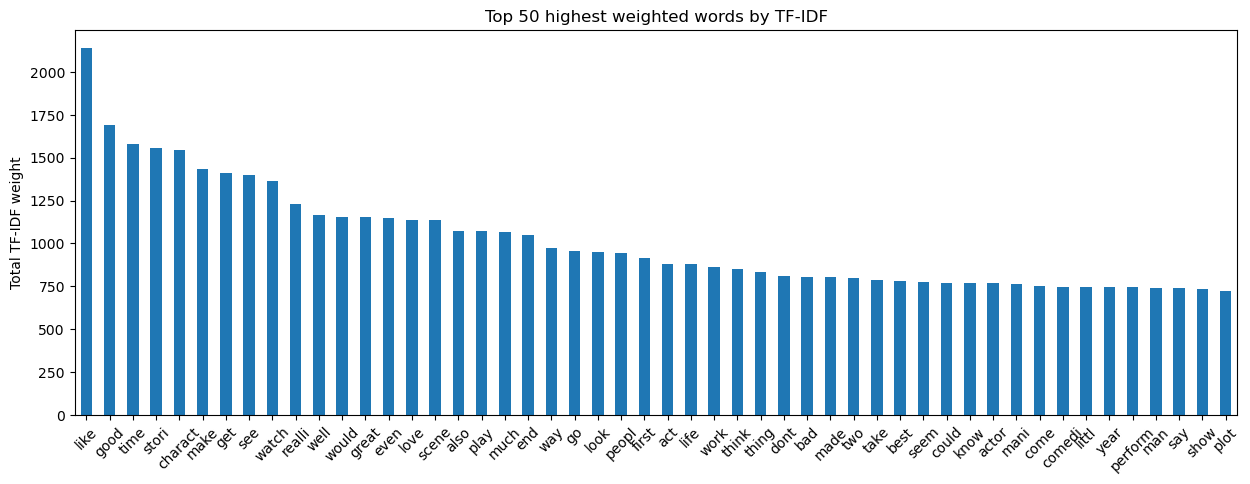

In [99]:
# Creates an array so we can graph it.
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(50).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 50 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

After the more refined search, the words seem more descriptive, with like and good being at the top, which are not as generic as the previous ones.

Now, to find the positive and negative keywords, we will need to perform a basic regression model so the positive and negative coefficients can be determined. We will run a linear regression with an L2 regularization coefficient. This is also known as a ridge regression. To tune the hyperparameter alpha, we will be running a randomized search for it to find the best hyperparameter, and then testing based off those values.

In [100]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

# produce randomized search to find good alpha value
# no need to scale results from tfidf since you are only including the data from the reviews

# Define the distribution of alpha to do a random search
alpha_distribution = {'alpha': np.random.uniform(low=0, high=10, size=1000)}

# Initialize the Ridge model
ridgeregression = Ridge()

search = RandomizedSearchCV(ridgeregression, alpha_distribution, cv=5, n_iter=100, random_state= 66)

# Fit the search
search.fit(X_train_transformed, y_train)


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100,
                   param_distributions={'alpha': array([3.59386075e+00, 2.83004657e+00, 5.40956240e+00, 2.61313216e+00,
       9.08538187e+00, 9.15017592e+00, 9.06232469e+00, 6.08496932e+00,
       4.12571720e+00, 8.31336265e+00, 4.93729050e+00, 4.49193063e+00,
       5.81501391e+00, 6.93431426e+00, 7.16304359e+00, 9.85144555e+00,
       6.30369607e+00, 9.3335...
       7.00546975e+00, 2.84076639e+00, 5.62283068e+00, 8.88506738e+00,
       4.95992043e+00, 1.61713116e+00, 5.91972995e+00, 9.23140651e+00,
       7.64711650e+00, 5.02453103e+00, 9.93833550e+00, 1.85759052e+00,
       4.75012130e+00, 8.39618934e-01, 6.58220728e+00, 7.43177337e+00,
       1.15657730e+00, 1.51462069e+00, 8.33378648e+00, 4.71118142e+00,
       8.17483036e+00, 8.97731952e+00, 1.59336246e+00, 9.31672997e+00])},
                   random_state=66)

In [101]:
# Print the best alpha value found by the randomized search
print("Best alpha value: ", search.best_params_['alpha'])

Best alpha value:  6.619060535630079


In [102]:
from sklearn.linear_model import Ridge, Lasso

ridge_reg = Ridge(alpha = search.best_params_['alpha'])
ridge_reg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {ridge_reg.score(X_train_transformed, y_train)}")

print(f"Validation score: {ridge_reg.score(X_val_transformed, y_val)}")

Train score: 0.3858958204675622
Validation score: 0.28996641970884995


Although the train and validation scores for this basic model do not seem very promising, this was a very rough model to get coefficients.

We will now look at the words with the highest positive and negative sentiments.

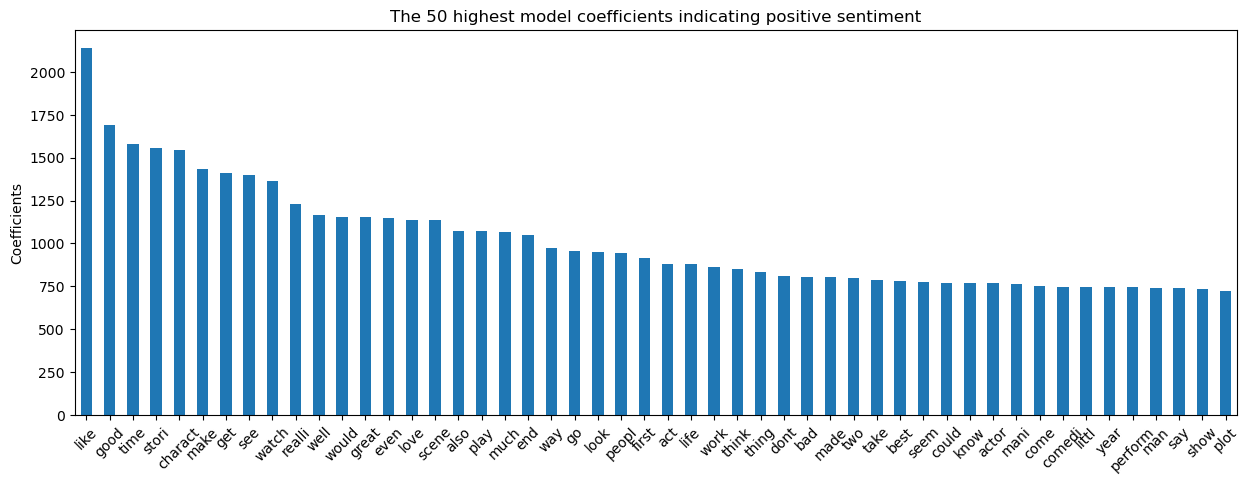

In [103]:
weighted_word_counts = pd.DataFrame(
    {"coefficients": ridge_reg.coef_[0]},
    index=vectorizer.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(50).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 50 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

For positive words, we see that words such as love, great, good, well all are present.

In [ ]:
# Accidentally reran this cell... will not be able to rerun it before submission time.

weighted_word_counts.sort_values("coefficients", ascending=True).head(100).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 50 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

For negative words, something strange has appeared, it seems the numbers have all taken place as the most negative words found in our data, due to time restraints we will not be filtering out numbers with a regexp command, however this will be addressed at the end of the project.

To join these words into our data, we will be doing so corresponding the the train, validation, and test sets.

The weighted words will be joined onto the Features or X part of our train, validation and test sets

In [105]:
# converting sparse matrix to dense
# Results show same row size as the train dataset

word_counts_dftrain = pd.DataFrame(X_train_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dftrain

,1,10,10 10,10 minut,10 year,100,1010,11,110,12,...,your fan,your go,your look,youth,youv,youv got,youv seen,zero,zone,
0,0.000000,0.021217,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.009429,...,0.0,0.0,0.0,0.022560,0.009072,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.011453,0.000000,0.000000,0.00000,0.004292,0.010048,0.005876,0.000000,0.003817,...,0.0,0.0,0.0,0.031968,0.003673,0.0,0.000000,0.005300,0.000000,0.021122
2,0.005208,0.004300,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.005732,...,0.0,0.0,0.0,0.000000,0.005515,0.0,0.008115,0.000000,0.000000,0.015858
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.070547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24982,0.000000,0.011734,0.000000,0.000000,0.00385,0.000000,0.000000,0.000000,0.008716,0.002607,...,0.0,0.0,0.0,0.115411,0.005017,0.0,0.003691,0.003620,0.000000,0.002404
24983,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.060021,0.000000,0.000000
24984,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.131075
24985,0.005099,0.008419,0.000000,0.008205,0.00000,0.012620,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.007792,0.000000,0.036227


In [106]:
# Joins the X train and the word weightings corresponding to X train together

X_train_words = pd.concat([X_train.reset_index(drop=True), word_counts_dftrain.reset_index(drop=True)], axis=1)
X_train_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
534    1967          0                18            5          8.0   
14973  1945          1                10            5         15.6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [107]:
# Repeat process for Validation 

# converting sparse matrix to dense
# Results show same row size as the val dataset

word_counts_dfval = pd.DataFrame(X_val_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dfval

,1,10,10 10,10 minut,10 year,100,1010,11,110,12,...,your fan,your go,your look,youth,youv,youv got,youv seen,zero,zone,
0,0.002655,0.019726,0.0,0.008544,0.0,0.0,0.0,0.004498,0.0,0.000000,...,0.0,0.004645,0.0,0.020974,0.000000,0.0,0.000000,0.008114,0.0,0.000000
1,0.003752,0.003097,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.019761,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.127831,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,0.000000,0.011888,0.0,0.023171,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.045747,0.0,0.044873,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,0.008479,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.008605
6243,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
6244,0.000000,0.008452,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011269,...,0.0,0.017915,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
6245,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [108]:
# Joins the X validation and the word weightings corresponding to X validation together

X_val_words = pd.concat([X_val.reset_index(drop=True), word_counts_dfval.reset_index(drop=True)], axis=1)
X_val_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
1488  2012          0                 4            5          7.6   
4054  2014          0                 2            5          5.8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [109]:
# Repeat process for Test

In [110]:
# converting sparse matrix to dense
# Results show same row size as the val dataset

word_counts_dftest = pd.DataFrame(X_test_transformed.todense(), columns = vectorizer.get_feature_names_out())
word_counts_dftest

,1,10,10 10,10 minut,10 year,100,1010,11,110,12,...,your fan,your go,your look,youth,youv,youv got,youv seen,zero,zone,
0,0.003317,0.005477,0.0,0.0,0.0,0.000000,0.000000,0.005620,0.000000,0.010953,...,0.0,0.0,0.000000,0.000000,0.003513,0.000000,0.005168,0.00000,0.000000,0.020201
1,0.000000,0.014316,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.022832,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.005098,0.0,0.0,0.0,0.022924,0.000000,0.010461,0.193108,0.000000,...,0.0,0.0,0.000000,0.016261,0.006539,0.000000,0.000000,0.00000,0.000000,0.018802
3,0.000000,0.008483,0.0,0.0,0.0,0.000000,0.014884,0.017407,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.010881,0.017351,0.000000,0.00000,0.000000,0.000000
4,0.013305,0.049425,0.0,0.0,0.0,0.008232,0.000000,0.011269,0.012237,0.021964,...,0.0,0.0,0.010619,0.000000,0.007044,0.011233,0.000000,0.02033,0.011759,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
13382,0.000000,0.020098,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
13383,0.017723,0.000000,0.0,0.0,0.0,0.000000,0.012835,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.008994
13384,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [111]:
# Joins the X test and the word weightings corresponding to X test together

X_test_words = pd.concat([X_test.reset_index(drop=True), word_counts_dftest.reset_index(drop=True)], axis=1)
X_test_words.sample(2)

Year  Sentiment  #Movies_directed  actor_count  Celeb_score  \
13262  1995          0                 7            5         10.8   
14     2016          0                 2            3          5.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

After joining the words to the features of each set of data, we will need to reset the indices of y, and do a final quality check to ensure that the row size of the data remains the same as when we created the train, validation, and test splits.

In [112]:
# Need to reset indices of the y

y_train = y_train.reset_index(drop = True)

y_val = y_val.reset_index(drop = True)

y_test = y_test.reset_index(drop = True)




In [113]:
# Doublechecking the train, val and test X and y

print(X_train_words.shape, y_train.shape)

print(X_val_words.shape, y_val.shape)

print(X_test_words.shape, y_test.shape)

(24987, 4304) (24987,)
(6247, 4304) (6247,)
(13386, 4304) (13386,)


The row size of each set seems to match the shape of the splits when we made them, we can proceed to saving them as CSV's individually.

In [116]:
# merge train X and y into one dataframe

train_df = pd.concat([X_train_words, y_train], axis=1)

#  Save the merged dataframe to a CSV file

train_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\train_df.csv', index=False)


In [117]:
# Repeat process for val

val_df = pd.concat([X_val_words, y_val], axis=1)

val_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\val_df.csv', index=False)

In [118]:
# Repeat process for test

test_df = pd.concat([X_test_words, y_test], axis=1)

test_df.to_csv(r'C:\Users\micha\OneDrive\Desktop\Capstone\test_df.csv', index=False)

# Notebook Conclusion

In this notebook, we have incorporated the second dataset we will be using, extracting positive and negative keywords by using a Term frequency inverse document frequency (TFIDF) vectorizer. Visualizations of the most frequent terms as well as the terms that were most likely to indicate positive sentiment as well as most likely to indicate negative sentiment were displayed.

In the next notebook, we will be showcasing our models, starting with a base model without term frequency, and then evaluating if our more advanced machine learning methods coupled with reviews will improve our base model.